In [45]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [40]:
df = pd.read_csv('train.csv')
#print(df)

In [37]:
with pd.option_context('display.max_columns', None):
    print(df.sample(5))

        id                keyword     location  \
6069  8669               sinkhole          NaN   
5542  7907  radiation%20emergency          NaN   
2362  3398             demolition          NaN   
5557  7932              rainstorm  Memphis, TN   
3737  5310                   fear          USA   

                                                   text  target  
6069  Sinkhole swallows Brooklyn intersection ÛÒ vi...       1  
5542  Who Else Wants Documents Radiation Emergency P...       0  
2362  7 Christians detained in Zhejiang amid widespr...       0  
5557  If you can't have the roar of the waves a rain...       0  
3737  Daily Reflections\nAugust 6\nDRIVEN\nDriven by...       0  


In [41]:
# pd.set_option('display.max_colwidth', None)
#print(df['keyword'].unique())
#print(df.isna().sum())
# df.sample(5)['text']

In [43]:
# print('shape before = ', df.shape)
# df = df.dropna()

In [20]:
df.describe()

,id,target
count,5080.000000,5080.000000
mean,5407.112598,0.432283
std,3116.359041,0.495442
min,48.000000,0.000000
25%,2728.750000,0.000000
50%,5360.500000,0.000000
75%,8086.000000,1.000000
max,10833.000000,1.000000


### Нормализация текста 

In [46]:
# Загрузка стоп-слов и лемматизатора
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция для очистки и нормализации текста
def normalize_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление ссылок и упоминаний
    text = re.sub(r'http\S+|www.\S+|@\w+|#\w+', '', text)
    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    # Токенизация
    words = text.split()
    # Удаление стоп-слов и лемматизация
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Объединение обратно в строку
    return ' '.join(words)

df['clean_text'] = df['text'].apply(normalize_text)

# Просмотр первых нескольких строк
print(df[['text', 'clean_text']].head())

[nltk_data] Downloading package stopwords to /Users/rust/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/rust/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/rust/nltk_data...


                                                                                                                                    text  \
0                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                                                                 Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected   
3                                                                      13,000 people receive #wildfires evacuation orders in California    
4                                               Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

                                                                              clean_text  
0                                                        deed reason

### Разделяем данные на обучающую и тестовую выборки 

In [48]:
from sklearn.model_selection import train_test_split

y = df['target']
X = df['clean_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Обучаем логистическую регрессию со стохастическим градиентным спуском, используя TF-IDF
#### - Преобразование текста в TF-IDF вектора

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Удаляем слова, которые встречаются менее чем в 5 документах
tfidf = TfidfVectorizer(min_df=5)

# Обучение словаря и преобразование текстов
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f'Размерность матрицы TF-IDF для тренинга: {X_train_tfidf.shape}')
print(f'Размерность матрицы TF-IDF для теста: {X_test_tfidf.shape}')

Размерность матрицы TF-IDF для тренинга: (6090, 1989)
Размерность матрицы TF-IDF для теста: (1523, 1989)


#### Обучение модели логистической регрессии, используя SGDClassifier 

In [63]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

sgd = SGDClassifier(loss='log_loss', random_state=42)

sgd.fit(X_train_tfidf, y_train)

y_train_pred = sgd.predict(X_train_tfidf)
y_test_pred = sgd.predict(X_test_tfidf)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

print(f'Точность на тренировочном наборе: {accuracy_train:.4f}')
print(f'Точность на тестовом наборе: {accuracy_test:.4f}')
print(f'F1-мера на тренировочном наборе: {f1_train:.4f}')
print(f'F1-мера на тестовом наборе: {f1_test:.4f}')

Точность на тренировочном наборе: 0.8629
Точность на тестовом наборе: 0.7879
F1-мера на тренировочном наборе: 0.8572
F1-мера на тестовом наборе: 0.7784


#### - Анализ слов с наибольшим весом 

In [65]:
feature_names = tfidf.get_feature_names_out()

# Коэффициенты модели
coefs = sgd.coef_[0]

weights_df = pd.DataFrame({'название слова': feature_names, 'вес': coefs})

top_positive = weights_df.sort_values(by='вес', ascending=False).head(10)
top_negative = weights_df.sort_values(by='вес').head(10)

print('Топ 10 положительных слов:')
print(top_positive)
print('\nТоп 10 отрицательных слов:')
print(top_negative)

Топ 10 положительных слов:
     название слова       вес
539      earthquake  3.235174
260      california  3.221177
215         bombing  3.220384
1678        suicide  3.141018
830       hiroshima  3.122982
1923       wildfire  3.109999
942          killed  3.084328
110          atomic  2.756953
1784          train  2.716877
1771        tornado  2.660067

Топ 10 отрицательных слов:
     название слова       вес
714            full -2.409359
1183            new -2.247688
872              im -2.214458
173          better -2.143300
1463           ruin -2.140092
990             let -2.129038
133             bag -2.117944
1883           want -2.048625
1248      panicking -2.038925
543            ebay -1.985938


#### Рисование графика функции потерь

Epoch 1/10, Loss на тренинге: 0.3753, Loss на тесте: 0.4729
Epoch 2/10, Loss на тренинге: 0.3689, Loss на тесте: 0.4691
Epoch 3/10, Loss на тренинге: 0.3687, Loss на тесте: 0.4687
Epoch 4/10, Loss на тренинге: 0.3689, Loss на тесте: 0.4686
Epoch 5/10, Loss на тренинге: 0.3693, Loss на тесте: 0.4686
Epoch 6/10, Loss на тренинге: 0.3695, Loss на тесте: 0.4686
Epoch 7/10, Loss на тренинге: 0.3697, Loss на тесте: 0.4686
Epoch 8/10, Loss на тренинге: 0.3699, Loss на тесте: 0.4686
Epoch 9/10, Loss на тренинге: 0.3701, Loss на тесте: 0.4686
Epoch 10/10, Loss на тренинге: 0.3702, Loss на тесте: 0.4686


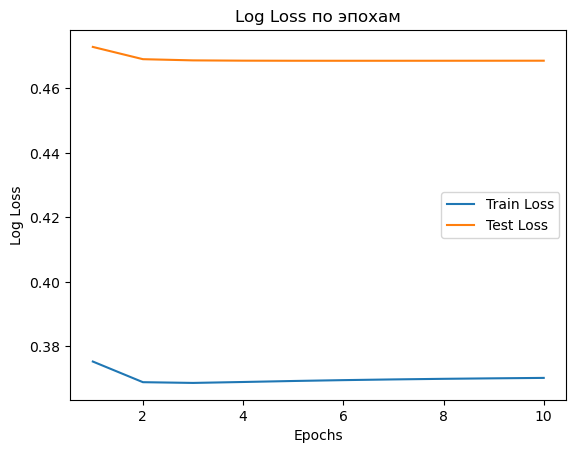

In [75]:
from sklearn.metrics import log_loss

n_epochs = 10
train_losses = []
test_losses = []

sgd = SGDClassifier(loss='log_loss', max_iter=1, tol=None, random_state=42)  # max_iter=1 для одной эпохи

for epoch in range(n_epochs):
    sgd.partial_fit(X_train_tfidf, y_train, classes=np.unique(y_train))
    # Предсказания вероятностей для вычисления лосса
    y_train_prob = sgd.predict_proba(X_train_tfidf)
    y_test_prob = sgd.predict_proba(X_test_tfidf)

    loss_train = log_loss(y_train, y_train_prob)
    loss_test = log_loss(y_test, y_test_prob)
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss на тренинге: {loss_train:.4f}, Loss на тесте: {loss_test:.4f}')

# Построение графика
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Log Loss по эпохам')
plt.legend()
plt.show()


#### видим, что на трейне и на тестев уже после первой эпохи ошибка ложиться на плато

### 4. L1 регуляризация. Эксперименты весами 

In [71]:
sgd_l1 = SGDClassifier(loss='log_loss', penalty='l1', alpha=0.0001, random_state=42)

sgd_l1.fit(X_train_tfidf, y_train)

y_train_pred_l1 = sgd_l1.predict(X_train_tfidf)
y_test_pred_l1 = sgd_l1.predict(X_test_tfidf)

accuracy_train_l1 = accuracy_score(y_train, y_train_pred_l1)
accuracy_test_l1 = accuracy_score(y_test, y_test_pred_l1)
f1_train_l1 = f1_score(y_train, y_train_pred_l1, average='macro')
f1_test_l1 = f1_score(y_test, y_test_pred_l1, average='macro')

print(f'Точность с L1 на тренировочном наборе: {accuracy_train_l1:.4f}')
print(f'Точность с L1 на тестовом наборе: {accuracy_test_l1:.4f}')
print(f'F1-мера с L1 на тренировочном наборе: {f1_train_l1:.4f}')
print(f'F1-мера с L1 на тестовом наборе: {f1_test_l1:.4f}')

Точность с L1 на тренировочном наборе: 0.8496
Точность с L1 на тестовом наборе: 0.7827
F1-мера с L1 на тренировочном наборе: 0.8434
F1-мера с L1 на тестовом наборе: 0.7739


#### показываем разницу, насколько увеличилась точность с L1 регуляризацией

In [74]:
print(f'Мера accuracy. Прирост точности с L1 на тренировочном наборе: {accuracy_train_l1 - accuracy_train:.4f}')
print(f'Мера accuracy. Прирост точности с L1 на тестовом наборе: {accuracy_test_l1 - accuracy_test:.4f}')
print(f'F1-мера. Прирост с L1 на тренировочном наборе: {f1_train_l1 - f1_train_l1:.4f}')
print(f'F1-мера. Прирост с L1 на тестовом наборе: {f1_test_l1 - f1_test:.4f}')

Мера accuracy. Прирост точности с L1 на тренировочном наборе: -0.0133
Мера accuracy. Прирост точности с L1 на тестовом наборе: -0.0053
F1-мера. Прирост с L1 на тренировочном наборе: 0.0000
F1-мера. Прирост с L1 на тестовом наборе: -0.0045


#### Таким образом видим, что в нашем примере L1 регуляризация не только не улучшила метрики accuracy и F1, но и ухудшила. Так что в данном примере её использовать нецелесообразно

#### Сравнение значений весов

In [76]:
# Коэффициенты модели без регуляризации
coefs_orig = sgd.coef_[0]
# Коэффициенты модели с L1-регуляризацией
coefs_l1 = sgd_l1.coef_[0]

# Подсчет нулевых весов
zeros_orig = np.sum(coefs_orig == 0)
zeros_l1 = np.sum(coefs_l1 == 0)

print(f'Количество нулевых весов без регуляризации: {zeros_orig}')
print(f'Количество нулевых весов с L1-регуляризацией: {zeros_l1}')

Количество нулевых весов без регуляризации: 0
Количество нулевых весов с L1-регуляризацией: 1198


#### L1-регуляризация способствует разреживанию весов, зануляя некоторые из них, фактически удаляя некоторые признаки. Это может помочь в отборе признаков (что делает модель проще и легче интерпретируемой) и предотвратить переобучение, уменьшает вычислительную нагрузку.


In [77]:
alphas = [0.0001, 0.001, 0.01, 0.1]
for alpha in alphas:
    sgd_l1 = SGDClassifier(loss='log_loss', penalty='l1', alpha=alpha, random_state=42)
    sgd_l1.fit(X_train_tfidf, y_train)
    y_test_pred_l1 = sgd_l1.predict(X_test_tfidf)
    accuracy_test_l1 = accuracy_score(y_test, y_test_pred_l1)
    f1_test_l1 = f1_score(y_test, y_test_pred_l1, average='macro')
    coefs_l1 = sgd_l1.coef_[0]
    zeros_l1 = np.sum(coefs_l1 == 0)
    print(f'alpha={alpha}, Accuracy={accuracy_test_l1:.4f}, F1-score={f1_test_l1:.4f}, Zero weights={zeros_l1}')

alpha=0.0001, Accuracy=0.7827, F1-score=0.7739, Zero weights=1198
alpha=0.001, Accuracy=0.6684, F1-score=0.5877, Zero weights=1950
alpha=0.01, Accuracy=0.5739, F1-score=0.3646, Zero weights=1989
alpha=0.1, Accuracy=0.5739, F1-score=0.3646, Zero weights=1989


alpha=1e-05, Accuracy=0.7466, F1-score=0.7411, Zero weights=326
alpha=0.0001, Accuracy=0.7827, F1-score=0.7739, Zero weights=1198
alpha=0.001, Accuracy=0.6684, F1-score=0.5877, Zero weights=1950
alpha=0.01, Accuracy=0.5739, F1-score=0.3646, Zero weights=1989
alpha=0.1, Accuracy=0.5739, F1-score=0.3646, Zero weights=1989


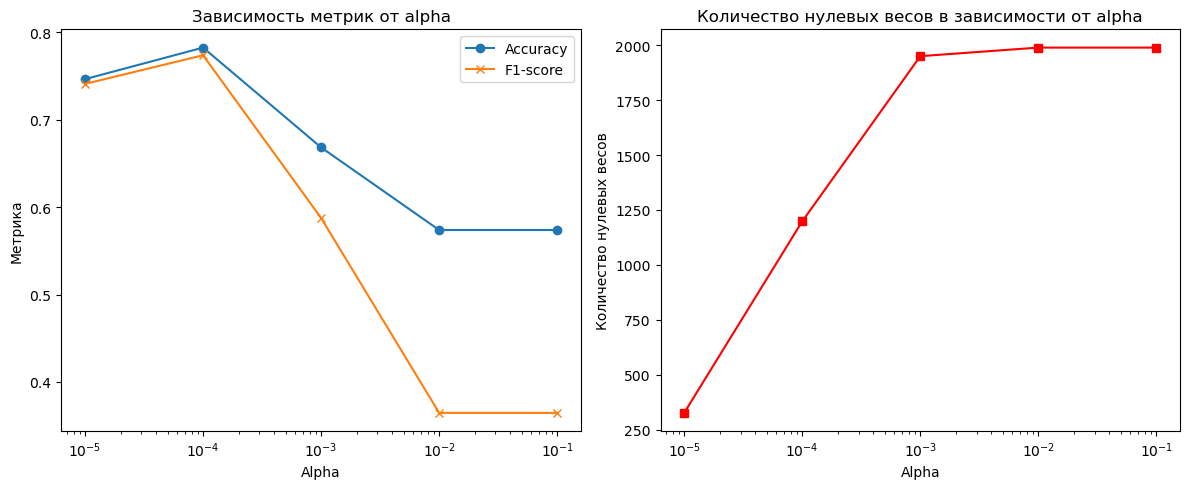

In [80]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
accuracy_scores = []
f1_scores = []
zero_weights = []

for alpha in alphas:
    sgd_l1 = SGDClassifier(loss='log_loss', penalty='l1', alpha=alpha, random_state=42, max_iter=1000, tol=1e-3)
    sgd_l1.fit(X_train_tfidf, y_train)
    y_test_pred_l1 = sgd_l1.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_test_pred_l1)
    f1 = f1_score(y_test, y_test_pred_l1, average='macro')
    coefs_l1 = sgd_l1.coef_[0]
    zeros_l1 = np.sum(coefs_l1 == 0)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    zero_weights.append(zeros_l1)
    print(f'alpha={alpha}, Accuracy={accuracy:.4f}, F1-score={f1:.4f}, Zero weights={zeros_l1}')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(alphas, accuracy_scores, marker='o', label='Accuracy')
plt.plot(alphas, f1_scores, marker='x', label='F1-score')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от alpha')
plt.legend()

plt.subplot(1,2,2)
plt.plot(alphas, zero_weights, marker='s', color='red')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Количество нулевых весов')
plt.title('Количество нулевых весов в зависимости от alpha')
plt.tight_layout()
plt.show()

#### из результатов видно, что при увеличении скорости обучения alpha усиливается степень регуляризации, больше коэффициентов становятся равными нулю, увеличивается скорость обучения, однако метрики Accuracy и F1 падают. Это говорит о том, что модель обладает худшей предсказательной способностью, она становится слишком простой и может недообучаться. 

### 5. Обучение нейронной сети с одним скрытым слоем с помощью PyTorch

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Преобразование матриц TF-IDF в тензоры
X_train_tensor = torch.from_numpy(X_train_tfidf.toarray()).float()
X_test_tensor = torch.from_numpy(X_test_tfidf.toarray()).float()
y_train_tensor = torch.from_numpy(y_train.values).long()
y_test_tensor = torch.from_numpy(y_test.values).long()

# Создаем датасеты и загрузчики данных
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [93]:
input_size = X_train_tfidf.shape[1]
# варьируемые параметры
hidden_size = 100  
output_size = 2 

class SimpleNN(nn.Module):
    def __init__(self, init_type=None):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        if init_type == 'zeros':
            nn.init.zeros_(self.fc1.weight)
            nn.init.zeros_(self.fc2.weight)
            
        elif init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [83]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Оценка на тестовом наборе
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        avg_test_loss = running_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

In [84]:
# Нулевая инициализация
model_zeros = SimpleNN(init_type='zeros')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_zeros.parameters(), lr=0.001)
num_epochs = 10

train_losses_zeros, test_losses_zeros = train_model(model_zeros, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.6560, Test Loss: 0.5714
Epoch [2/10], Train Loss: 0.4678, Test Loss: 0.4582
Epoch [3/10], Train Loss: 0.3816, Test Loss: 0.4610
Epoch [4/10], Train Loss: 0.3447, Test Loss: 0.4720
Epoch [5/10], Train Loss: 0.3230, Test Loss: 0.4870
Epoch [6/10], Train Loss: 0.3034, Test Loss: 0.5029
Epoch [7/10], Train Loss: 0.2955, Test Loss: 0.5230
Epoch [8/10], Train Loss: 0.2804, Test Loss: 0.5368
Epoch [9/10], Train Loss: 0.2716, Test Loss: 0.5563
Epoch [10/10], Train Loss: 0.2645, Test Loss: 0.5782


In [85]:
# Xavier инициализация
model_xavier = SimpleNN(init_type='xavier')
optimizer = optim.Adam(model_xavier.parameters(), lr=0.001)

train_losses_xavier, test_losses_xavier = train_model(model_xavier, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.6134, Test Loss: 0.5105
Epoch [2/10], Train Loss: 0.4241, Test Loss: 0.4556
Epoch [3/10], Train Loss: 0.3559, Test Loss: 0.4687
Epoch [4/10], Train Loss: 0.3166, Test Loss: 0.4929
Epoch [5/10], Train Loss: 0.2904, Test Loss: 0.5137
Epoch [6/10], Train Loss: 0.2714, Test Loss: 0.5353
Epoch [7/10], Train Loss: 0.2534, Test Loss: 0.5609
Epoch [8/10], Train Loss: 0.2367, Test Loss: 0.5942
Epoch [9/10], Train Loss: 0.2231, Test Loss: 0.6168
Epoch [10/10], Train Loss: 0.2092, Test Loss: 0.6438


In [86]:
# he инициализация
model_he = SimpleNN(init_type='he')
optimizer = optim.Adam(model_he.parameters(), lr=0.001)

train_losses_he, test_losses_he = train_model(model_he, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.6250, Test Loss: 0.5225
Epoch [2/10], Train Loss: 0.4338, Test Loss: 0.4599
Epoch [3/10], Train Loss: 0.3563, Test Loss: 0.4697
Epoch [4/10], Train Loss: 0.3194, Test Loss: 0.4884
Epoch [5/10], Train Loss: 0.2911, Test Loss: 0.5107
Epoch [6/10], Train Loss: 0.2717, Test Loss: 0.5335
Epoch [7/10], Train Loss: 0.2532, Test Loss: 0.5638
Epoch [8/10], Train Loss: 0.2355, Test Loss: 0.5856
Epoch [9/10], Train Loss: 0.2264, Test Loss: 0.6125
Epoch [10/10], Train Loss: 0.2076, Test Loss: 0.6426


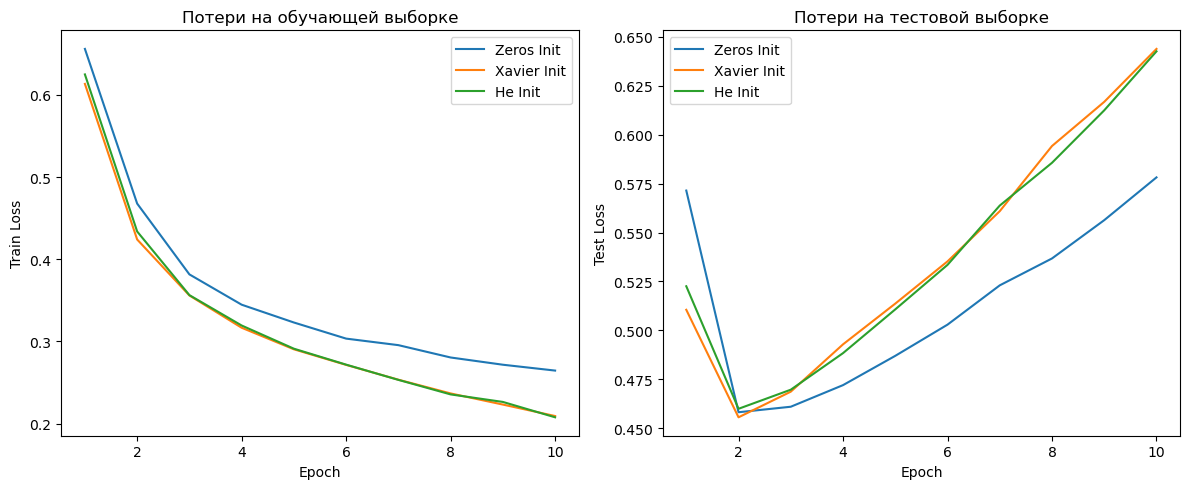

In [87]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses_zeros, label='Zeros Init')
plt.plot(epochs, train_losses_xavier, label='Xavier Init')
plt.plot(epochs, train_losses_he, label='He Init')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Потери на обучающей выборке')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, test_losses_zeros, label='Zeros Init')
plt.plot(epochs, test_losses_xavier, label='Xavier Init')
plt.plot(epochs, test_losses_he, label='He Init')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Потери на тестовой выборке')
plt.legend()

plt.tight_layout()
plt.show()

#### Исходя из графиков ошибок видно, что модель с инициализациями: нулевая, xavier, he переобучается, так как loss-функция на тренировочной выборке стабильно падает, а на тестовой начинает со второй эпохи увеличиваться. Также видно, что модель с нулевой инициализацией весов имеет худшие показатели изменения функции ошибки на тренировочных данных, но несмотря на это, для неё ошибка на тестовой выборке растёт меньше всего, что значит, что и модель переобучается меньше. Модель с нулевой инициализацией, как правило, работает плохо, поскольку все нейроны получают одинаковые обновления и модель может не обучаться. 

In [88]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    return accuracy, f1_macro, f1_micro

In [90]:
# Оценка моделей 

accuracy_zeros, f1_macro_zeros, f1_micro_zeros = evaluate_model(model_zeros, test_loader)
accuracy_xavier, f1_macro_xavier, f1_micro_xavier = evaluate_model(model_xavier, test_loader)
accuracy_he, f1_macro_he, f1_micro_he = evaluate_model(model_he, test_loader)

print('Results with Zero Initialization:')
print(f'Accuracy: {accuracy_zeros:.4f}, F1 Macro: {f1_macro_zeros:.4f}, F1 Micro: {f1_micro_zeros:.4f}\n')

print('Results with Xavier Initialization:')
print(f'Accuracy: {accuracy_xavier:.4f}, F1 Macro: {f1_macro_xavier:.4f}, F1 Micro: {f1_micro_xavier:.4f}\n')

print('Results with He Initialization:')
print(f'Accuracy: {accuracy_he:.4f}, F1 Macro: {f1_macro_he:.4f}, F1 Micro: {f1_micro_he:.4f}')

Results with Zero Initialization:
Accuracy: 0.7584, F1 Macro: 0.7525, F1 Micro: 0.7584

Results with Xavier Initialization:
Accuracy: 0.7525, F1 Macro: 0.7467, F1 Micro: 0.7525

Results with He Initialization:
Accuracy: 0.7466, F1 Macro: 0.7405, F1 Micro: 0.7466


In [92]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Logistic Regression with L1', 'NN Zero Init', 'NN Xavier Init', 'NN He Init'],
    'Accuracy': [accuracy_test, accuracy_test_l1, accuracy_zeros, accuracy_xavier, accuracy_he],
    'F1 Macro': [f1_test, f1_test_l1, f1_macro_zeros, f1_macro_xavier, f1_macro_he],
    'F1 Micro': [f1_test, f1_test_l1, f1_micro_zeros, f1_micro_xavier, f1_micro_he]
})

results

,Model,Accuracy,F1 Macro,F1 Micro
0,Logistic Regression,0.787919,0.778378,0.778378
1,Logistic Regression with L1,0.573867,0.364622,0.364622
2,NN Zero Init,0.758372,0.752478,0.758372
3,NN Xavier Init,0.752462,0.746685,0.752462
4,NN He Init,0.746553,0.740479,0.746553


#### - 1. Обычная логистическая регрессия показала лучшие результаты по всем метрикам
#### - 5. Логистическая регрессия с L1-регуляризацией показала худшие результаты в целом и по сравнению с обычной логистической регрессией в частности, возможно из-за чрезмерного упрощения.
#### - 2. Нейронная сеть с нулевой инициализацией заняла второе место.
#### - 3. Нейронная сеть с xavier-инициализацией заняла третье место.
#### - 4. Нейронная сеть с he-инициализацией показала четвёртое место.
